# Donald Trump's personality assesment with Twitter and IBM Watson

Much has been written about **Donald Trump**’s character concerning his **fitness for office** but very little of it was grounded in science. 

By building on previous research to label the data and leveraging IBM's Personality Insight API, this analysis of Trump's Twitter communications will allow us to gain **unbiased insights** into Donald J. Trump's personality as well as **his mindset during the 2016 presidential election.**

## Data Pre-processing

The dataset was acquired from **Brendan Brown**'s [Trump Twitter Archive](www.trumptwitterarchive.com/about) and contains all the publicly available and deleted tweets from the **@realDonaldTrump** account from *2009 up to the 13th August 2020*. 

Retweets and manual retweets were excluded at download and after de-duplication, over **35 thousand communications** remained.

For any politician, **multiple staff** members express themselves through a single account and are therefore identified to be a **single individual**. Not only does this makes it difficult for the public to understand who their elected official really is, but it would skew our personality analysis as well. 

Thanks to Dr. James Allen-Robertson and his [deep learning approach to recognizing Trump's tweets](https://towardsdatascience.com/finding-trump-with-neural-networks-4419468e0624), we know it is possible to use machine learning to predict if the president was really behind the keyboard. A simple Naive Bayes classifier with **81% accuracy** on unseen data was used to pre-label the data which was then verified qualitatively and re-labeled by hand when necessary.

In [4]:
import pandas, numpy

tweets = pandas.read_csv('./data/realdonaldtrump.csv', 
                       parse_dates=['date'],
                       index_col=['date'],
                       usecols=['date', 'content'],
                       encoding='utf-8')

tweets.head(3)

,content
date,
2009-05-04 13:54:25,Be sure to tune in and watch Donald Trump on L...
2009-05-04 20:00:10,Donald Trump will be appearing on The View tom...
2009-05-08 08:38:08,Donald Trump reads Top Ten Financial Tips on L...


## IBM Watson and the Personality Insights API:

In order to move quickly to our objective, we will utilize IBM's Watson Personality Insights API.


![personality insights landing page](./doc/IBM-personality-insight.jpeg)
>Gain insight into how and why people think, act, and feel the way they do.  
>This service applies linguistic analytics and personality theory to infer attributes from a person's unstructured text. 

If you want to know more about the science behind the service, [click here.](https://cloud.ibm.com/docs/personality-insights?topic=personality-insights-science) But in short, by using thousands of **Twitter surveys** (International Personality Item Pool or IPIP) and their **associated communications**, as well as in-house research, IBM created a machine learning regressor based on the Five-Factor and NEO-PI models to **infer personality traits**, values and needs of a social media user. 

This is the exact same technology created by **Christopher Wylie**, the chief data analyst turned whistle-blower at **Cambridge Analytica**. The company that was contracted to manipulate the public on social media during **Trump's electoral campaign** and **Brexit**. Please refer to [Mindf*ck](https://www.amazon.co.uk/Mindf-Inside-Cambridge-Analyticas-Break/dp/1788164997) written by Mr. Wylie himself if you are interested in the full report of the incident.                                 

A demonstration is available [here](https://personality-insights-demo.ng.bluemix.net/) but if you wish to use the service regularly, please apply for an API key as follow;
- [Sign up for an IBM Cloud account](https://cloud.ibm.com/registration?)
- Create an instance of the Personality Insights service and get your credentials:
     - Go to the Personality Insights page in the IBM Cloud Catalog.
     - Click Create.
     - Click Show to view the service credentials.

In [162]:
import getpass

# prompt for API credentials
API_URL = getpass.getpass('Your instance url: ')
API_KEY = getpass.getpass('Your API key: ')

Your instance url:  ···········································································································
Your API key:  ············································


In [163]:
import sys, requests 
from io import StringIO

def get_profile_data(text):
    """
    Send request to the Personality Insights API
    Note: data max size is 20Mb and min size is 100 words
    """    
    # check size limit
    assert (sys.getsizeof(text)*1e-6) <= 20.0, 'Text data > 20Mb'
    assert len(text.split()) > 100, 'Text data < 100 words'
    
    # prepare api version, csv parameters and headers
    url = API_URL + '/v3/profile?version=2017-10-13&csv_headers=true'444444445
    headers = {
        'Content-Type': 'text/plain;charset=utf-8',
        'Accept': 'text/csv',
    }
    # send request 
    response = requests.post(url, headers=headers, 
                             auth=('apikey', API_KEY), 
                             data=text.encode('utf-8'))
    # response to df
    result = StringIO(str(response.content.decode("utf-8") ))
    result_df = pandas.read_csv(result)
    
    return result_df 

*Note: Due to the API's limitations (20Mb), only the last 30K tweets will be used to build the account's general profile.*

In [164]:
# concat last 30K tweets     
text_data = ' '.join(tweets.tail(30000).content)

# request profile 
general_profile = get_profile_data(text_data)

# save and display profile
general_profile.to_csv('./data/general_profile.csv', index=False)
general_profile

,big5_agreeableness,facet_altruism,facet_cooperation,facet_modesty,facet_morality,facet_sympathy,facet_trust,big5_conscientiousness,facet_achievement_striving,facet_cautiousness,...,need_challenge_significant,need_closeness_significant,need_curiosity_significant,need_excitement_significant,need_harmony_significant,value_conservation_significant,value_hedonism_significant,value_openness_to_change_significant,value_self_enhancement_significant,value_self_transcendence_significant
0,0.638308,0.870628,0.617919,0.056688,0.716919,0.894446,0.76559,0.702012,0.933529,0.686098,...,True,True,True,True,True,True,True,True,True,True


## So, what are the big five personality traits?

The Big Five Model, also known as the Five-Factor Model, is the most widely accepted **personality theory** held by psychologists today. At least four sets of researchers have worked for decades on this problem and have identified generally the same five factors; **extraversion**, **agreeableness**, **openness**, **conscientiousness**, and **neuroticism**.

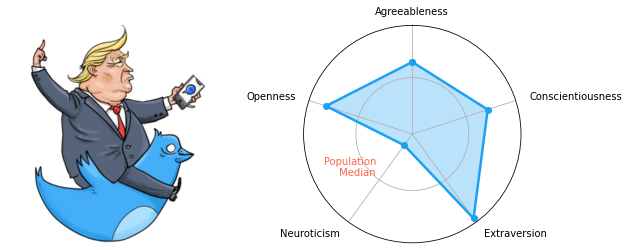

In [6]:
from math import pi
from PIL import Image
import matplotlib.pyplot as plt


# change plot size 
plt.rcParams['figure.figsize'] = [10,4]

def plot_img(path, ax):
    """
    Plot image in axis
    """
    image = Image.open(path)
    ax.imshow(image)
    ax.axis('off')    
    
def category_plot_radar(category_name, data, ax=plt.subplot(polar=True)):
    """
    Radar plot type of personality profile: big5 or facet
    """
    column_selection = [ column for column in data.columns \
                        if category_name in column \
                        and not any(word in column for word in ['raw', 'significant']) ]
    
    # closing the plot by repeating the first value
    values = data[column_selection].values.tolist()[0]
    values += values[:1]
    
    # determine angles for category
    m = len(column_selection)
    angles = numpy.linspace(0, 2 * numpy.pi, m, endpoint=False).tolist()
    angles += angles[:1]
    
    # radar plot 
    ax.plot(angles, values, marker='.', color='#1da1f2', 
            linewidth=2.5, markersize=12)
    ax.fill(angles, values, color='#1da1f2', alpha=0.3)
    
    # fix axis to vertical alignment 
    ax.set_theta_offset(numpy.pi / 2)
    ax.set_theta_direction(-1)
    
    # xticks
    plt.xticks(angles[:-1], [' '.join(col.split('_')[1:]).title() \
                                     for col in column_selection])
    
    # adjust xtick label alignment based on it's position on the circle.
    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, numpy.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < numpy.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')
    # ytick 
    ax.set_rlabel_position(220)
    plt.yticks([0.5], ['Population\n Median'], color='tomato', ha='right')
    
    
# plotting big5 as bar plot 
big5 = general_profile[[ column for column in general_profile.columns \
                        if 'big5' in column \
                        and not any(word in column for word in ['raw', 'significant']) ]]
# plot image 
ax1 = plt.subplot(121)
plot_img('./doc/trump-tweet-1.png', ax=ax1)
#ax1.set_title('@realDonaldTrump', loc='left', fontsize=18)

# plotting traits as radar 
ax2 = plt.subplot(122, polar=True)
category_plot_radar('big5', general_profile, ax=ax2)

*Note: You can have a look [here](https://medium.com/python-in-plain-english/radar-chart-basics-with-pythons-matplotlib-ba9e002ddbcd) if you want to learn more about radar plots with matplotlib.*

**Openness**, is the tendency to be imaginative, open to new ideas, curious and creative. People who score high in openness are often interested in creative pursuits.

**Conscientiousness** is about having attention to detail and a good work ethic. People who score highly in conscientiousness tend to want to get things done on time, the proper way, and tend to follow rules.

**Agreeableness**, like extraversion, is about interpersonal style. People who score highly on agreeableness tend to be warm, trusting, kind and cooperative. They tend to adjust to others, rather than forcing their own ways on them.

**Neuroticism** refers to the tendency to respond with negative emotions to threat, frustration, or loss, like anxiety, sadness, anger, envy and jealousness. People who score highly on neuroticism tend to experience frequent and intense emotional reaction, while people who score lower tend to be more emotionally stable and calm.

**Extraversion** is the trait most associated with those who like to be the life of the party, those people who really enjoy socialising and spending time with others. If you'd prefer to snuggle up with a good book by yourself rather than head to the pub, you're likely to score lower on extraversion.  

## The relationship between Traits and Facets
One common criticism of the Big Five is that it does not explain all of human behavioral aspects as it only represents broad personality domains. To add granularity to the Five Factors, the **NEO-PI model** was developed and further improved by **Paul Costa** and **Robert McCrae**. It subdivides each of the five traits into collections of 6 facets: 

In [7]:
# selecting only big5 and facets 
bi5_and_facets = [col for col in general_profile.columns \
                  if any(domain in col for domain in \
                         ['big5', 'facet']) \
                  and not 'significant' in col]

# group facets by big5 (split list every seven items)
facet_groups = [bi5_and_facets[n:n+7] \
                for n in range(0, len(bi5_and_facets), 7)]

# group to dictionary with formated traits as keys 
facet_groups = {group[0].split('_')[1].title(): group[1:] for group in facet_groups}

# place neuroticism to the end 
facet_groups['Neuroticism'] = facet_groups.pop('Neuroticism')

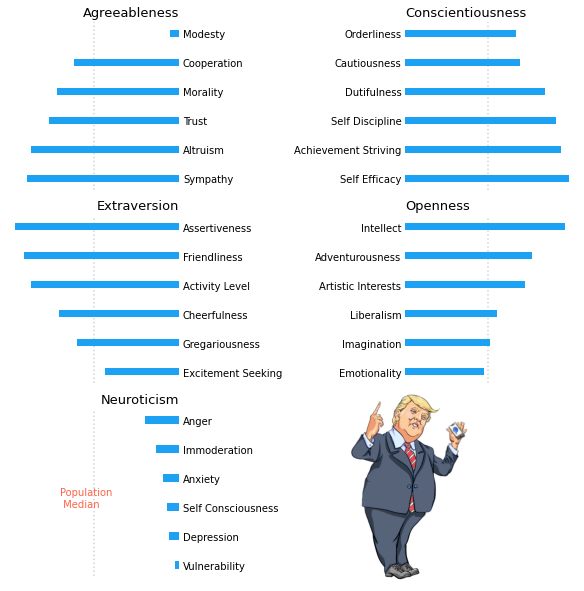

In [33]:
# prepare axes 
fig, axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, sharex='col')
axes = [ax for sublist in axes for ax in sublist]
#axes[-1].remove()

# change plot size 
plt.rcParams['figure.figsize'] = [8,8]

color_groups = []

for i, (ax, (trait, facets)) in enumerate(zip(axes, facet_groups.items())):
    # invert axis for symmetry
    ax.invert_xaxis()
    
    # plot population median 
    ax.axvline(0.5, color='lightgrey', linestyle=':', zorder=0)
    
    # move y ticks for symmetry 
    ax.yaxis.tick_right()
    if i%2 > 0: ax.yaxis.tick_left()
    
    # special sorting for the two top plots
    ascending = True
    if i in [0, 1]: ascending = False
    
    # prepare data to plot 
    df = general_profile[facets].sort_values(by=0, ascending=ascending, axis=1)
    error = numpy.random.rand(len(df.columns))
    columns = [' '.join(title.split('_')[1:]).title() for title in df.columns]
    
    # plot facets
    ax.barh(columns, df.values[0], color='#1da1f2', align='center', height=0.25)
    ax.set_title(trait, loc=('right', 'left')[i%2>0], fontsize=13)
    
    # remove spines and ticks 
    for spine in ['left', 'right', 'bottom', 'top']:
        ax.spines[spine].set_visible(False)
    ax.tick_params(axis='both', which='both',length=0)
    ax.set_xticklabels([])
    
    # add legend to Neuroticism ax
    if trait == 'Neuroticism':
        ax.text(0.7, 2, 'Population\n Median', color='tomato')


# reposition axes to fit image in the graph
pos = axes[-1].get_position()
pos.x0 = 0.6       
pos.y0 = -0.03
axes[-1].set_position(pos)

# remove shared x axes
axis_group = axes[-1].get_shared_x_axes()
axis_group.remove(axes[-1])

# plot image
plot_img('./doc/trump-tweet-5.png', axes[-1])


As a result of this analysis, we can infer that Donald Trump is an **extrovert**, **sympathetic** and **highly assertive** person who **does not know modesty**. 
A more worrisome observation is regarding his **unbelievably low neuroticism**; Mr. Trump would apparently stay completely "unfazed" under any circumstances, in an almost **psychopathic** fashion, as seen at the 2011 White House Correspondance.

## Personality timeline
A general profile is useful to comprehend the *psychological baseline* of a person. However, this analysis aims to discover the **evolution of the user's mindset** during the span of the available data (11 years).

Due to the large number of communications, plotting successive profiles from quarterly resampled tweets helps us develop such insight. Here, the NEO-PI facets with the most variations were extracted for clarity. 


In [39]:
%%time

df_list = []
# resample by quarter
for quarter, data in tweets.groupby(pandas.PeriodIndex(tweets.index, freq='Q')):
    print(f'[INFO] Period {quarter}: {data.shape[0]} tweets')

    # fetch the profile for this period
    df = get_profile_data(data.content)
    df['date'] = quarter
    
    # append to result list 
    df_list.append(df)

# concat results
quarterly_profile = pandas.concat(df_list)
quarterly_profile.set_index('date', inplace=True)

# save and display 
quarterly_profile.to_csv('./data/timeline_profile.csv')
quarterly_profile.head(3)

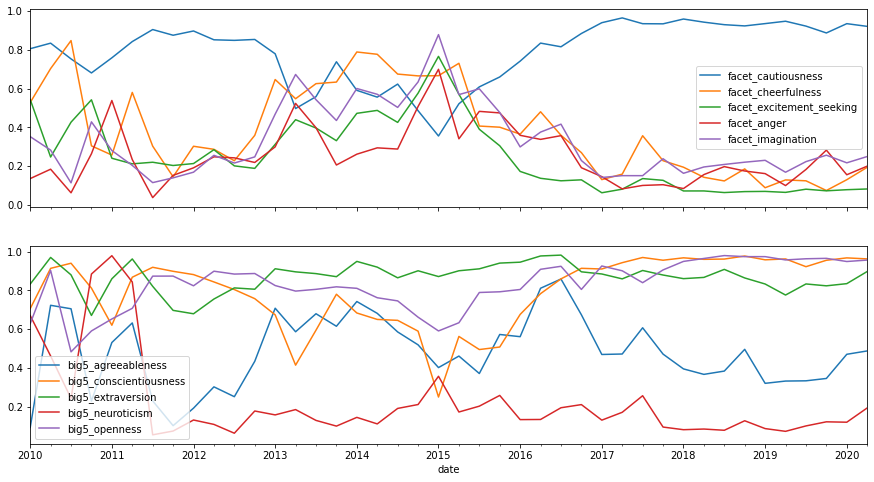

In [59]:
# Extracting the facets with the most variations starting from 2012.
quarterly_facet = quarterly_profile[[ column for column in quarterly_profile.columns \
                    if 'facet' in column \
                    and not any(word in column for word in ['raw', 'significant']) ]]

quarterly_facet_selection =  quarterly_facet.columns[(quarterly_facet[quarterly_facet.index > '2012']
                                                    .apply(lambda x: x.max()-x.min(), axis=0) > 0.6)]
# facet axis
ax1 = plt.subplot(211)
category_plot_line('facet', quarterly_profile[quarterly_facet_selection], ax=ax1, legend=True)

# big5 axis
ax3 = plt.subplot(212, sharex=ax1)
category_plot_line('big5', quarterly_profile, ax=ax3, legend=True)

The correlation between important life events and distress in the user's base character appears clearly when considering the following timeline;

- [**2011Q2 - Infamous White House Correspondance**](https://time.com/3991301/donald-trump-barack-obama/): 

    The day President Barack Obama and comedian Seth Meyers mocked Donald Trump mercilessly. Here is a part of the transcript; 
    
    
>Donald Trump is here tonight. 
>Now I know that he’s taken some flak lately. But no one is happier—no one is prouder—to put this birth certificate matter to rest than The Donald. 
>And that’s because he can finally get back to focusing on the issues that matter: Like, did we fake the moon landing? What really happened in Roswell? And where are Biggie and Tupac? 
>All kidding aside, obviously we all know about your credentials and breadth of experience. 
>For example… no seriously, just recently, in an episode of Celebrity Apprentice, at the steakhouse, the men’s cooking team did not impress the judges from Omaha Steaks. And there was a lot of blame to go around, but you, Mr. Trump, recognized that the real problem was a lack of leadership, and so ultimately you didn’t blame Lil Jon or Meat Loaf, you fired Gary Busey. 
>And these are the kinds of decisions that would keep me up at night. Well handled, sir. Well handled. 
>Say what you will about Mr. Trump, he certainly would bring some change to the White House. Let’s see what we’ve got up there.
        
>*Barack Obama, 2011 White House Correspondance*
        
        
- [**2013Q2 - Miss Universe Pagent in Moscow, Russia**](https://www.theguardian.com/us-news/2017/sep/18/trump-in-moscow-what-happened-at-miss-universe-in-2013): 
    
    This is when Trump met with Aras Agalarov, the billionaire owner of the Crocus Group corporation to, allegedly, plan Russia's meddling in the American Elections.
    
- [**2015Q1 - Start of the Hilary Clinton Email Controversy**](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy):

    Hillary Clinton's private email server, while she was Secretary of State, became publicly known on March 2, 2015.  
    
- [**2016Q4 - Donald Trump wins the Persidential Election**]()


# Conclusion

While this analysis has been kept unbiased so far, this conclusion won't be. Keep in mind that I am not a psychology expert, and the following comments should be considered my personal opinion. However, I have met this (character) before;

If you ever organized a "house party", Mr. Donald J. Trump would be the "big man" with a towering posture, a goon, and a loud gregarious voice almost bullying you to believe people only came to hear about his countless female conquests, even though he wasn't invited in the first place. You could repeatedly tell him that he isn't wanted at your party, but it wouldn't stop him from openly flirting with your fiancé and dismissing your intellect to soothe his inferiority complex and narcissism.

More importantly, after this analysis, we can all fully appreciate how **thorough and dangerous** this technology is. Thankfully, the IBM Watson Personality Insight API will be deprecated in December 2021, but anyone with 300$ could re-create it rather easily.

I think that the most nefarious way to use this model to date is filtering job applicants based on their **inferred** psychological profiles; I **know** the causes of mental illnesses to be a mix of intelligence, socio-economical situation, and parental education. Now, childhood difficulties are inevitable but do we, as a civilization, want to refuse highly intelligent people the opportunity to get their lives back together with engaging, well-paid jobs? Or, do we want to seclude a large part of the population out of society because of our prejudiced views on mental health? And if so, why was the Donald allowed to be the president of the most powerful country in the world? 